In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

import spacy
import nltk


from hyperopt import tpe,hp
from hyperopt.fmin import fmin
from scipy.stats import entropy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

import pyLDAvis.lda_model

from spacy.lang.nl.stop_words import STOP_WORDS

from helper import process_dutch_text, extract_product_content, metrics

nltk.download('stopwords')

# Load the spaCy model for Dutch
nlp = spacy.load("nl_core_news_sm")

import pyLDAvis

sns.set_theme(context='notebook',
              style='white',
              palette='deep',
            #   font='Lucida Calligraphy',
              font_scale=1,
              color_codes=True,
              rc=None)

# Configurate matplotlib settings

plt.rcParams['figure.facecolor'] = '#F0F8FF'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.edgecolor'] = 'green'
plt.rcParams['figure.frameon'] = True

plt.rcParams["figure.autolayout"] = True

plt.rcParams['axes.facecolor'] = '#F5F5DC'
plt.rcParams['axes.titlesize'] = 18   
plt.rcParams["axes.titleweight"] = 'normal'
plt.rcParams["axes.titlecolor"] = 'Olive'
plt.rcParams['axes.edgecolor'] = 'pink'

plt.rcParams["axes.linewidth"] = 2
plt.rcParams["axes.grid"] = True
plt.rcParams['axes.titlelocation'] = 'center' 
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.labelpad"] = 2
plt.rcParams['axes.labelweight'] = 1
plt.rcParams["axes.labelcolor"] = 'Olive'
plt.rcParams["axes.axisbelow"] = False 
plt.rcParams['axes.xmargin'] = .2
plt.rcParams["axes.ymargin"] = .2

plt.rcParams["xtick.bottom"] = True 
plt.rcParams['xtick.color'] = '#A52A2A'
plt.rcParams["ytick.left"] = True  
plt.rcParams['ytick.color'] = '#A52A2A'

plt.rcParams['axes.grid'] = True 
plt.rcParams['grid.color'] = 'green'
plt.rcParams['grid.linestyle'] = '--' 
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['grid.alpha'] = .3       

plt.rcParams['legend.loc'] = 'best' 
plt.rcParams['legend.facecolor'] =  'NavajoWhite'  
plt.rcParams['legend.edgecolor'] = 'pink'
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.fontsize'] = 12


plt.rcParams['font.size'] = 12

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.edgecolor'] = 'Blue'

/usr/local/Caskroom/miniconda/base/envs/linh-dev/lib/python3.10/site-packages/scikitplot/plotters.py:33: DeprecationWarning: This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0
  warnings.warn("This module was deprecated in version 0.3.0 and its functions "
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linh.nguyen3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data Exploration

In [2]:
df = pd.read_csv('./data/clickdata.csv')

### Clean target
- To simplify, we binary classied human vs. non-human (2 labels or imbalanced binary classification)

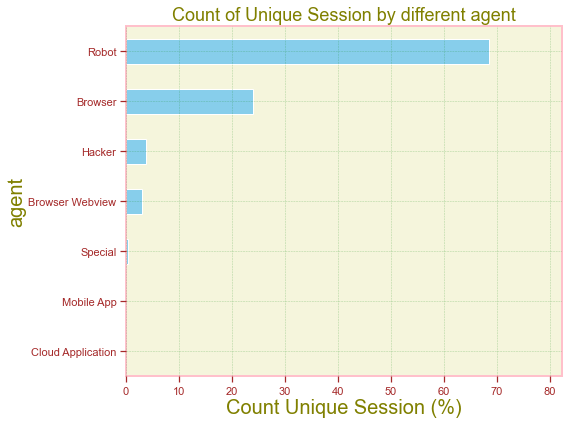

In [3]:
df["place"] = df["country_by_ip_address"] + "_" + df["region_by_ip_address"]
df = df.replace(np.nan, '', regex=True)
df = df.replace('Unknown', '', regex=True)
df = df.replace('Unknown', '', regex=True)

# Merge all different 'non hunam' types
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Robot Mobile','Robot')

n_session = df.session_id.nunique()
# Get counts for each 'ua_agent_class'
counts = 100*df.groupby('ua_agent_class').agg({"session_id": lambda x: x.nunique()}).sort_values("session_id") / n_session

# Plot horizontal bar chart
counts.plot(kind='barh', color='skyblue', 
            figsize=(8, 6), 
            legend=False, 
            xlabel='Count Unique Session (%)',
            ylabel = 'agent',
            title = 'Count of Unique Session by different agent'
           )
plt.show()

- Robot accounts for ~70% of traffic

## Traffic by country

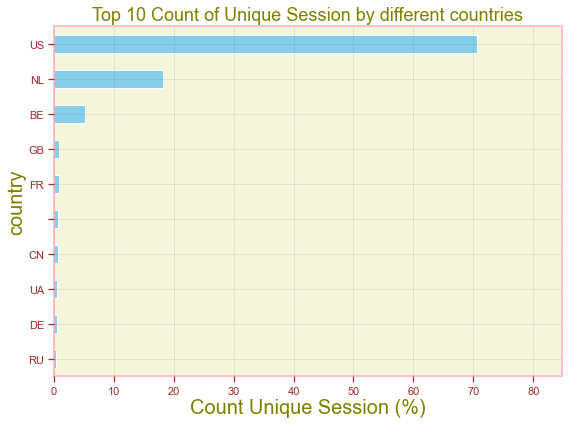

In [4]:
counts = 100*df.groupby('country_by_ip_address').agg({"session_id": lambda x: x.nunique()}).sort_values("session_id") / n_session
top = 10
# Plot horizontal bar chart
counts.iloc[-top:].plot(kind='barh', color='skyblue', 
            figsize=(8, 6), 
            legend=False, 
            xlabel='Count Unique Session (%)',
            ylabel = 'country',
            title = f'Top {top} Count of Unique Session by different countries'
           )
plt.show()

## Traffic by country by region

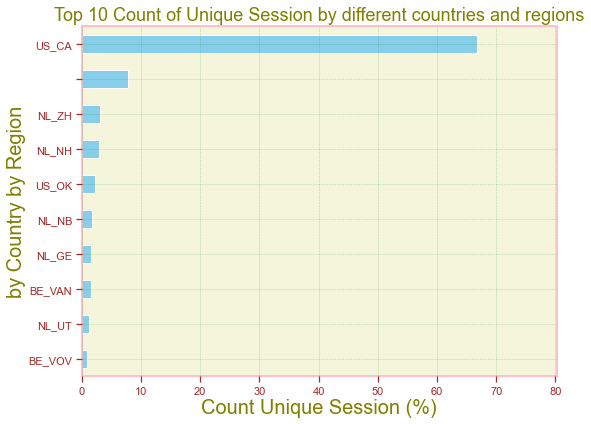

In [5]:
counts = 100*df.groupby('place').agg({"session_id": lambda x: x.nunique()}).sort_values("session_id") / n_session
top = 10
# Plot horizontal bar chart
counts.iloc[-top:].plot(kind='barh', color='skyblue', 
            figsize=(8, 6), 
            legend=False, 
            xlabel='Count Unique Session (%)',
            ylabel = 'by Country by Region',
            title = f'Top {top} Count of Unique Session by different countries and regions'
           )
plt.show()

- Traffic from California of USA accounts for ~70% of traffic

## Traffic by visitor_recognition_type

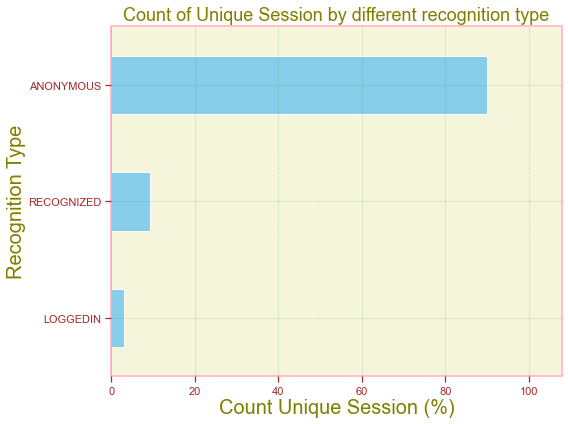

In [6]:
counts = 100*df.groupby('visitor_recognition_type').agg({"session_id": lambda x: x.nunique()}).sort_values("session_id") / n_session
# Plot horizontal bar chart
counts.plot(kind='barh', color='skyblue', 
            figsize=(8, 6), 
            legend=False, 
            xlabel='Count Unique Session (%)',
            ylabel = 'Recognition Type',
            title = f'Count of Unique Session by different recognition type'
           )
plt.show()

- Most traffics (> 80%) are anonymized

## Referrer
- assume null means no referrer

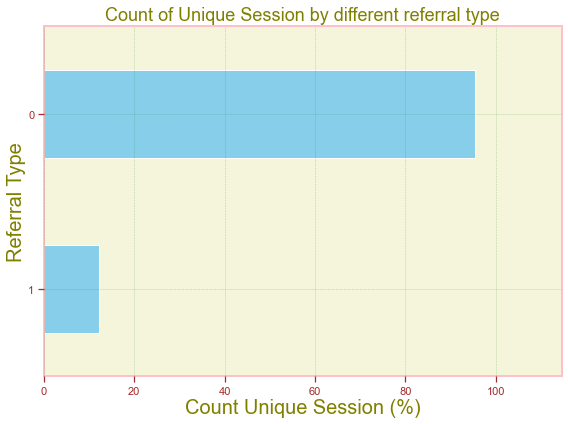

In [7]:
df["referer_boolean"] = np.where(df.referrer_without_parameters == '', 0, 1)
counts = 100*df.groupby('referer_boolean').agg({"session_id": lambda x: x.nunique()}).sort_values("session_id") / n_session
# Plot horizontal bar chart
counts.plot(kind='barh', color='skyblue', 
            figsize=(8, 6), 
            legend=False, 
            xlabel='Count Unique Session (%)',
            ylabel = 'Referral Type',
            title = f'Count of Unique Session by different referral type'
           )
plt.show()

- We saw some session which have both referrer and no referrer, maybe it's worth to check with how simulate those columns
(assuming session can be exclusively either referred or not)

### Extract Date

In [8]:
df['datetime'] = pd.to_datetime(df['epoch_ms'], unit='ms')

# Extract date, day of the week, hour, minute, and second
df['date'] = df['datetime'].dt.date
df['dayweek'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

In [9]:
df.groupby("hour").agg({"session_id": lambda x: x.nunique()})

,session_id
hour,
20,17584
21,13518


In [10]:
df["date"].nunique()

1

- Data are only available from 20-22 for 1 day, and also we don't know when the session ends, so it's unlikely time feature (or seasonality) plays an important role here

# 2. APPROACH

- Since >95% traffic comes from Browsers and Robots, we can simplify the multi-label classification problem into binary classication between Robots vs. non-Robots. Any multi-label classication problem can be divided into multiple binary classification anyway, with one vs.rest strategy
- The class Robot/non-Robot is imbalance ~0.6/1, so it's imbalance binary classification
- It seems there're 3 consistent features: country, region, and visitor recognition type. In fact, country and region can be combined into 1 feature e.g. place
- We can approximately extract the product category from url by topic modeling (Latent Dirichlet Allocation). The assumption is that bot/robot browsing are only interested in some specific products
- For simplicity, the data were split into train/test data before modeling, assuming all columns/features are still the same in the test set. However it's noted some corner cases which can happen in reality, e.g.:
  - There're new countries/regions in the test set which are unavailable in the training set
  - Or new product categories in the test set

### TWO MODELS ARE EVALUATED

#### Baseline kNN Model
- Simply one-hot encoding `country_by_ip_address`, `region_by_ip_address`, `visitor_recognition_type` as feature inputs
- The default kNN from scikit-learn using k = 5

#### Random forest model
- Feature Engineering:
  - Country and region are combined for `place` feature, where only top most 20 places with traffic are kept the name, while the rest is grouped into `Others`
  - From url, clean text, extract the product content, and modeling the topic, serving as product category (feature: product_topic).
  - Since all features: `place`, `product_topic` and `visitor_recognition_type` are categorical, instead of using one-hot encoding which expands the dimensionality, count encoding (based on unique session) is implemented
- Hyperparameters Tuning: using Hyperopt library

### FLOWCHART CAN BE SUMMARIZED

<div style="background-color: white; padding: 10px; display: inline-block;">
<img src="./img/flowchart.png" alt="Alt text" style="width: 1000px;"/>
</div>

## Data Processing and Engineering

### TOPIC MODELING WITH LDA
- The aim was to see if any specific products/items where non-human traffic targeted

##### CLEAN TEXT FIRST

In [11]:
df["clean_url"] = df["url_without_parameters"].apply(extract_product_content)
df["product_content"] = df["clean_url"].apply(process_dutch_text)

#### Convert target to either robot or non-robot (binary)

In [12]:
df["binary_agent_target"] = np.where(df["ua_agent_class"] == "Robot", 1, 0) 
# display(df)

#### Top product contents between Robot vs. non-robot agent

/Users/linh.nguyen3/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/linh.nguyen3/.local/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


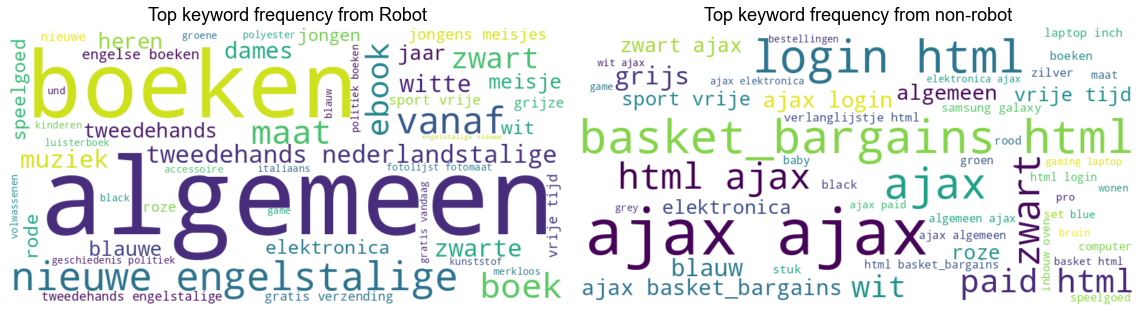

In [13]:
nword=50
robot_word = " ".join(df[df.ua_agent_class == "Robot"]["product_content"])
human_word = " ".join(df[df.ua_agent_class != "Robot"]["product_content"])

# robot_word = " ".join(list(set(robot_word.split(" "))))
# human_word = " ".join(list(set(human_word.split(" "))))

wordcloud_robot = WordCloud(width=800, height=400, background_color="white", max_words=nword).generate(robot_word)
word_frequencies = wordcloud_robot.words_
robot_text = [word for word in word_frequencies.keys()]

wordcloud_human = WordCloud(width=800, height=400, background_color="white", max_words=nword).generate(human_word)
word_frequencies = wordcloud_human.words_
human_text = [word for word in word_frequencies.keys()]

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_robot, interpolation="bilinear")
plt.title(f"Top keyword frequency from Robot", color='black', fontsize=18)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_human, interpolation="bilinear")
plt.title(f"Top keyword frequency from non-robot", color='black', fontsize=18)
plt.axis("off")

plt.tight_layout()

plt.show()

- We noted there're some distinction in product keywords between Robot and non-Robot. Traffic from Robot focuses on general, book or language topics, while traffic driven by non-Robot would center around ajax, or sports

#### Divide product content into 10 different topics, serving as product category (10 categories)

In [14]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words=list(STOP_WORDS),   # Dutch Stopwords          
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{4,}',  
                             max_features=5000,          
                            )

vectorized = vectorizer.fit_transform(df['product_content'])
model_lda = LatentDirichletAllocation(n_components=10, # Number of topics
                                      random_state=42,       
                                      n_jobs = -1 
                                     )

lda_output = model_lda.fit_transform(vectorized)

#### What are those topics?

In [15]:
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the most important words for each topic
top_words = []
for topic_idx, topic in enumerate(model_lda.components_):
    top_words_indices = topic.argsort()[:-10 - 1:-1]
    top_words.append([feature_names[i] for i in top_words_indices])

# Print the top words for each topic
for i, words in enumerate(top_words):
    print(f"Topic {i + 1} - Top 10 words: {', '.join(words)}")

Topic 1 - Top 10 words: inch, jaar, laptop, zwart, houten, puzzel, wonen, gaming, lego, homedecoration
Topic 2 - Top 10 words: samsung, speelgoed, zwart, galaxy, case, wierook, iphone, plus, zwarte, hoesje
Topic 3 - Top 10 words: sport, tijd, vrije, accessoires, bestellingen, witte, bruin, activity, small, black
Topic 4 - Top 10 words: zwart, baby, stuks, muis, draadloze, zilver, delig, body, olympus, grijs
Topic 5 - Top 10 words: engelstalige, zwart, heren, maat, nieuwe, boek, dames, inbouw, bosch, ebook
Topic 6 - Top 10 words: ajax, computer, groene, multi, phantom, house, microsoft, religie, spiritualiteit, thread
Topic 7 - Top 10 words: html, basket, boeken, bargains, login, paid, verlanglijstje, engelse, school, kantoor
Topic 8 - Top 10 words: algemeen, zwart, elektrische, philips, vidaxl, green, blauw, radio, grey, acer
Topic 9 - Top 10 words: muziek, zwart, roze, mini, oven, maat, blauw, gezond, mooi, volwassenen
Topic 10 - Top 10 words: jongens, elektronica, meisjes, maat, enge

In [16]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(model_lda, vectorized, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      67.596931  40.077393       1        1  11.754053
0     -20.798374 -41.206642       2        1  11.268241
1      19.232906  60.613152       3        1  11.079223
9      33.058128 -51.462269       4        1  10.491228
3      63.300900 -13.325352       5        1  10.489790
8      33.385090  18.225775       6        1  10.140928
6      12.265017 -15.902639       7        1   9.679001
2     -43.907669   0.147210       8        1   9.195583
7      -6.644641  19.440683       9        1   8.799023
5     -29.972418  53.106449      10        1   7.102930, topic_info=          Term         Freq        Total Category  logprob  loglift
77        ajax  6496.000000  6496.000000  Default  30.0000  30.0000
1916      html  3882.000000  3882.000000  Default  29.0000  29.0000
91    algemeen  1720.000000  1720.000000  Default  28.0000  28.0000
303     basket  1469.000000  1469.000000  Default  27.0000  27.0000
471     boeken  1431.000000  1431.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2238      kobo    26.504899    57.852057  Topic10  -5.9211   1.8641
3284      plus    40.314982   274.886785  Topic10  -5.5017   0.7250
585      buggy    39.582407   293.271401  Topic10  -5.5200   0.6419
4045     stand    21.978686    34.006870  Topic10  -6.1083   2.2082
2443     light    21.806011    60.484961  Topic10  -6.1162   1.6245

[494 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
15        8  0.995319  accessoires
21        9  0.992317         acer
26        6  0.120337        actie
26        9  0.030084        actie
26       10  0.842360        actie
...     ...       ...          ...
4985      8  0.056799        zwart
4985      9  0.132262        zwart
4986      3  0.761937       zwarte
4986      4  0.236463       zwarte
4988      2  0.991612      zwembad

[717 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 10, 4, 9, 7, 3, 8, 6])

- Each bubble represents a topic. The area of these topic bubles is proportional to the amount of words that belong to each topic across the dictionary. The bubles are plotted using a multidimensional scaling algorithm (dimensional reduction) based on the words they comprise, so topics that are closer together have more words in common.
- Blue bars represent the overall frequency of the term across the entire corpus. Salient is a specific metric for topic identity. Higher saliency values indicate that a word is more useful for identifying a specific topic. 
- Red bars estimate frequency of the term in a selected topic
- Relevance aims to highlight terms that are not only important within a specific topic but also distinctive to that topic compared to their general frequency in the corpus.

In [17]:
# Get the product topic with the maximum probability
# If there're 2 values maximum probability, pick the first one
df['product_topic'] = lda_output.argmax(axis=1) + 1 
display(df.head())

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,place,referer_boolean,datetime,date,dayweek,hour,minute,second,clean_url,product_content,binary_agent_target,product_topic
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.website.com/nl/l/nederlandstalige-...,,ANONYMOUS,Robot,US_CA,0,2018-03-05 20:00:01.034,2018-03-05,Monday,20,0,1,nederlandstalige-kunstgeschiedenis-theorie-ove...,nederlandstalige kunstgeschiedenis theorie knu...,1,1
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.website.com/nl/l/italiaans-natuur-...,,ANONYMOUS,Robot,US_CA,0,2018-03-05 20:00:01.590,2018-03-05,Monday,20,0,1,italiaans-natuur-wetenschap-kinderboeken-over-...,italiaans natuur wetenschap kinderboeken visse...,1,5
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.website.com/nl/p/nespresso-magimix...,https://www.website.com/nl/p/nespresso-magimix...,ANONYMOUS,Browser,IT_LI,1,2018-03-05 20:00:02.397,2018-03-05,Monday,20,0,2,nespresso-magimix-inissia-m105-koffiemachine-grey,nespresso magimix inissia koffiemachine grey,0,9
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.website.com/nl/l/nieuwe-engelstali...,,ANONYMOUS,Robot,US_CA,0,2018-03-05 20:00:02.598,2018-03-05,Monday,20,0,2,nieuwe-engelstalige-outdoor-sportboeken-algeme...,nieuwe engelstalige outdoor sportboeken algeme...,1,5
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.website.com/nl/l/nieuwe-actie-avon...,,ANONYMOUS,Robot,US_CA,0,2018-03-05 20:00:04.428,2018-03-05,Monday,20,0,4,nieuwe-actie-avontuur-over-prive-detective,nieuwe actie avontuur prive detective,1,6


#### ENTROPY ANALYSIS
- Now we have necessary features, calculating the weighted entropy per feature w.r.t targets to see which features have least entropy in term of unique sessions

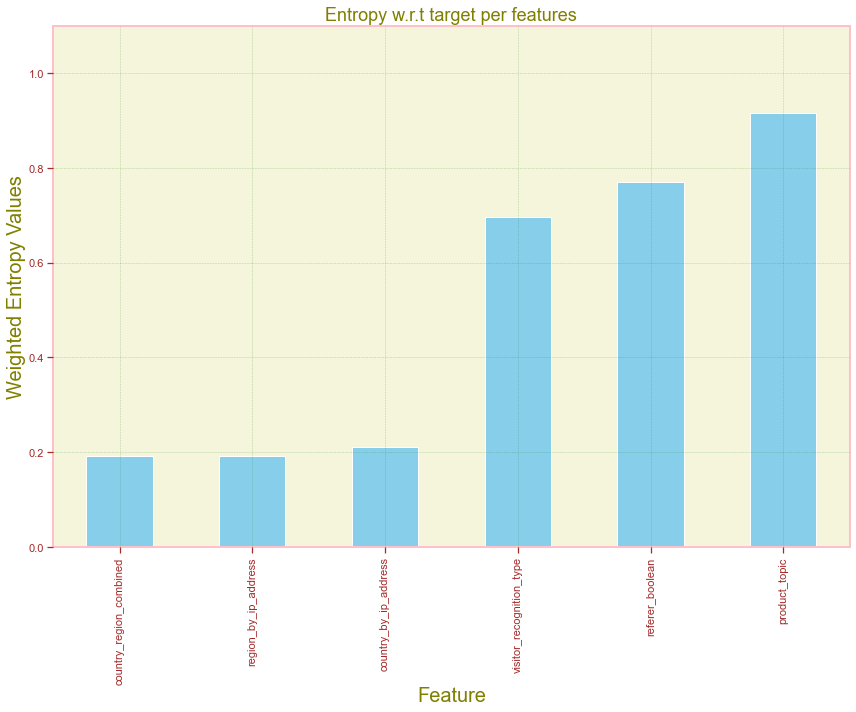

In [18]:
entropy_dict = {}

for i in ["country_by_ip_address", 
          "region_by_ip_address", 
          "place",
          "visitor_recognition_type", 
          "referer_boolean", 
          "product_topic"
          ]:

    pivot_table = pd.pivot_table(df, values='session_id', index=str(i), columns='binary_agent_target', aggfunc=lambda x: x.nunique(), fill_value=0)
    
    # Reset the index and rename the columns
    pivot_table = pivot_table.reset_index()
    pivot_table.columns = [f'{i}', 'class_0', 'class_1']
    pivot_table["total"] = pivot_table[['class_0', 'class_1']].sum(axis=1) # Traffic Count
    pivot_table["P_total"] = pivot_table["total"]/ pivot_table["total"].sum()
    pivot_table["entropy"] = pivot_table[['class_0', 'class_1']].apply(entropy, base = 2, axis=1)
    pivot_table["w_entropy"] = pivot_table['entropy'] * pivot_table['total'] # entropy with weights traffic count
    w_entropy = pivot_table["w_entropy"].sum() / pivot_table["total"].sum()
    if i == "place":
        i = "country_region_combined"
    entropy_dict[i] = [w_entropy]

entropy_df = pd.DataFrame(entropy_dict).T
entropy_df = entropy_df.sort_values(by=0, ascending=True)
entropy_df.plot(kind='bar', color='skyblue', 
                figsize=(12, 10), 
                legend=False, 
                xlabel='Feature',
                ylabel = 'Weighted Entropy Values',
                title = f'Entropy w.r.t target per features'
           )
plt.show()

- We see obvisouly location features are the most predictive here, to distinguish between Robots and nonRobots
- `product_topic` has the highest entropy (least predictive), but it's noted it also means there's some improvement needed in text and topic modeling

#### CRAMER V CORRELATION ANALYSIS
- Check the association among those categorical variables


In [19]:
categorical_columns = ["country_by_ip_address", 
          "region_by_ip_address", 
          "place",
          "visitor_recognition_type", 
          "referer_boolean", 
          "product_topic",
          "binary_agent_target"
          ]

# Create an empty matrix to store Cramer's V values
cramer_v_matrix = np.zeros((len(categorical_columns), len(categorical_columns)))
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        contingency_table = pd.crosstab(df[categorical_columns[i]], df[categorical_columns[j]])
        chi2, _, _, _ = stats.chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        cramer_v_matrix[i, j] = cramer_v
        cramer_v_matrix[j, i] = cramer_v
cramer_v_df = pd.DataFrame(cramer_v_matrix, columns=categorical_columns, index=categorical_columns)
display(cramer_v_df)

,country_by_ip_address,region_by_ip_address,place,visitor_recognition_type,referer_boolean,product_topic,binary_agent_target
country_by_ip_address,0.000000,0.850126,0.912134,0.381113,0.482606,0.146615,0.923635
region_by_ip_address,0.850126,0.000000,1.000000,0.410043,0.533137,0.172869,0.957523
place,0.912134,1.000000,0.000000,0.411988,0.537736,0.175170,0.957523
visitor_recognition_type,0.381113,0.410043,0.411988,0.000000,0.330908,0.267900,0.448502
referer_boolean,0.482606,0.533137,0.537736,0.330908,0.000000,0.406437,0.425380
product_topic,0.146615,0.172869,0.175170,0.267900,0.406437,0.000000,0.356476
binary_agent_target,0.923635,0.957523,0.957523,0.448502,0.425380,0.356476,0.000000


Variables: region_by_ip_address and place, Cramer's V: 1.0
Variables: place and region_by_ip_address, Cramer's V: 1.0
Variables: place and binary_agent_target, Cramer's V: 0.9575227463271977
Variables: binary_agent_target and place, Cramer's V: 0.9575227463271977
Variables: region_by_ip_address and binary_agent_target, Cramer's V: 0.9575227462861978
Variables: binary_agent_target and region_by_ip_address, Cramer's V: 0.9575227462861978
Variables: country_by_ip_address and binary_agent_target, Cramer's V: 0.9236346730008558
Variables: binary_agent_target and country_by_ip_address, Cramer's V: 0.9236346730008558
Variables: country_by_ip_address and place, Cramer's V: 0.912133718913668
Variables: place and country_by_ip_address, Cramer's V: 0.912133718913668
Variables: country_by_ip_address and region_by_ip_address, Cramer's V: 0.8501259565409903
Variables: region_by_ip_address and country_by_ip_address, Cramer's V: 0.8501259565409903
Variables: place and referer_boolean, Cramer's V: 0.53

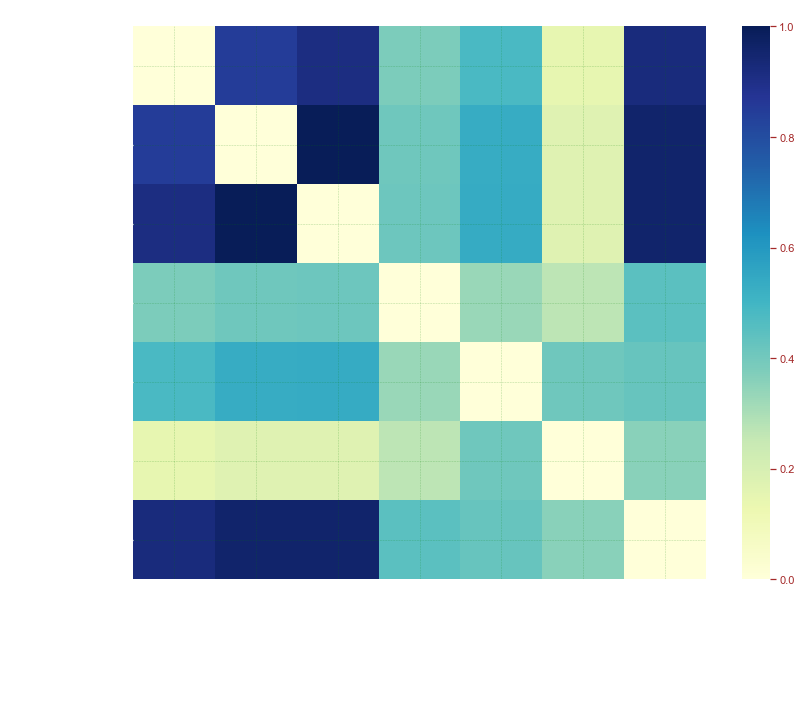

In [20]:
# Assuming you have the cramer_v_df DataFrame
# Define a threshold for a strong association (e.g., 0.4 or higher)
threshold = 0.4

# Iterate through the DataFrame to find pairs with a strong association
strong_associations = []

for column1 in cramer_v_df.columns:
    for column2 in cramer_v_df.columns:
        if column1 != column2 and cramer_v_df.loc[column1, column2] >= threshold:
            strong_associations.append((column1, column2, cramer_v_df.loc[column1, column2]))

# Sort the list of strong associations by Cramer's V value (if needed)
strong_associations.sort(key=lambda x: x[2], reverse=True)

# Print the pairs with strong associations
for association in strong_associations:
    print(f"Variables: {association[0]} and {association[1]}, Cramer's V: {association[2]}")

plt.figure(figsize=(12, 10))
sns.heatmap(cramer_v_df, cmap="YlGnBu", fmt=".2f")
plt.title("Cramer's V Heatmap",color='white')
plt.tick_params(axis="both", colors="white")
plt.show()


- It is obvious place and robots are highly associated. This means, e.g. if a traffic is from US_CA, it's highly likely Robot traffic
- There's no strong evidence and association that Robot only targets some specific product

#### Count Encoding for Random Forest

In [21]:
# Build visitor recognition type encoder
encoder_visit_type = df.groupby("visitor_recognition_type").agg({"session_id": lambda x: x.nunique()}).to_dict()["session_id"]
display(encoder_visit_type)

# Select top 20 traffic place, the rest puts into Others
top = 20
session_by_place = df.groupby("place").agg({"session_id": lambda x: x.nunique()}).reset_index()
top20_place = session_by_place.sort_values(by="session_id", ascending=False)["place"].iloc[:top].tolist()
top20_place = [x for x in top20_place if x != '']
df['simplified_place'] = np.where(df['place'].isin(top20_place), df['place'], 'Others')
# Build place encoder
encoder_place = df.groupby("simplified_place").agg({"session_id": lambda x: x.nunique()}).to_dict()["session_id"]
display(encoder_place)

{'ANONYMOUS': 27695, 'LOGGEDIN': 923, 'RECOGNIZED': 2847}

{'BE_BRU': 132,
 'BE_VAN': 467,
 'BE_VBR': 133,
 'BE_VLI': 161,
 'BE_VOV': 298,
 'BE_VWV': 150,
 'CN_BJ': 223,
 'NL_GE': 471,
 'NL_GR': 123,
 'NL_LI': 222,
 'NL_NB': 525,
 'NL_NH': 893,
 'NL_OV': 233,
 'NL_UT': 373,
 'NL_ZH': 960,
 'Others': 4124,
 'US_CA': 20596,
 'US_NY': 123,
 'US_OK': 678,
 'US_WA': 124}

#### Encoded features for random forest

In [22]:
df["encoded_place"] = df["simplified_place"].map(encoder_place)
df["encoded_visit_type"] = df["visitor_recognition_type"].map(encoder_visit_type)
display(df)

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,place,referer_boolean,...,hour,minute,second,clean_url,product_content,binary_agent_target,product_topic,simplified_place,encoded_place,encoded_visit_type
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.website.com/nl/l/nederlandstalige-...,,ANONYMOUS,Robot,US_CA,0,...,20,0,1,nederlandstalige-kunstgeschiedenis-theorie-ove...,nederlandstalige kunstgeschiedenis theorie knu...,1,1,US_CA,20596,27695
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.website.com/nl/l/italiaans-natuur-...,,ANONYMOUS,Robot,US_CA,0,...,20,0,1,italiaans-natuur-wetenschap-kinderboeken-over-...,italiaans natuur wetenschap kinderboeken visse...,1,5,US_CA,20596,27695
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.website.com/nl/p/nespresso-magimix...,https://www.website.com/nl/p/nespresso-magimix...,ANONYMOUS,Browser,IT_LI,1,...,20,0,2,nespresso-magimix-inissia-m105-koffiemachine-grey,nespresso magimix inissia koffiemachine grey,0,9,Others,4124,27695
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.website.com/nl/l/nieuwe-engelstali...,,ANONYMOUS,Robot,US_CA,0,...,20,0,2,nieuwe-engelstalige-outdoor-sportboeken-algeme...,nieuwe engelstalige outdoor sportboeken algeme...,1,5,US_CA,20596,27695
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.website.com/nl/l/nieuwe-actie-avon...,,ANONYMOUS,Robot,US_CA,0,...,20,0,4,nieuwe-actie-avontuur-over-prive-detective,nieuwe actie avontuur prive detective,1,6,US_CA,20596,27695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59777,1520287193332,6a98ec825aa0ccdc2aefb0d02f291cde,NL,NH,https://www.website.com/nl/p/gladskin-rosacea-...,,RECOGNIZED,Browser,NL_NH,0,...,21,59,53,gladskin-rosacea-gel-15-ml,gladskin rosacea gel,0,1,NL_NH,893,2847
59778,1520287193930,70664825c07eeb2af81c77e7ef6f7493,US,CA,https://www.website.com/nl/p/homedecoration-to...,,ANONYMOUS,Robot,US_CA,0,...,21,59,53,homedecoration-toronto-fotolijst-fotomaat-36x4...,homedecoration toronto fotolijst fotomaat alum...,1,1,US_CA,20596,27695
59779,1520287196302,99935d53a2f5d6e95adaecba3ec288e6,US,CA,https://www.website.com/nl/l/witte-nike-sports...,,ANONYMOUS,Robot,US_CA,0,...,21,59,56,witte-nike-sportshirts-s,witte nike sportshirts,1,3,US_CA,20596,27695
59780,1520287197700,0bff91927029f6402eff065680b0d8d8,US,CA,https://www.website.com/nl/l/gadgetbay-randapp...,,ANONYMOUS,Robot,US_CA,0,...,21,59,57,gadgetbay-randapparatuur-euro-10-euro-25,gadgetbay randapparatuur,1,1,US_CA,20596,27695


### 3. MODELING

#### TRAIN/TEST SPLIT

In [23]:
# Baseline
knn_feature = ['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type']
# Random Forest
rf_feature = ["encoded_place", "encoded_visit_type", "referer_boolean", "product_topic"]
all_feature = knn_feature + rf_feature
target = "binary_agent_target"
# weights = df
# # one hot encoding for kNN features
# knn_X = pd.get_dummies(data=df[knn_feature], drop_first=True)
X = df[all_feature]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
train_index = X_train.index.tolist()
test_index = X_test.index.tolist()

#### kNN BASELINE

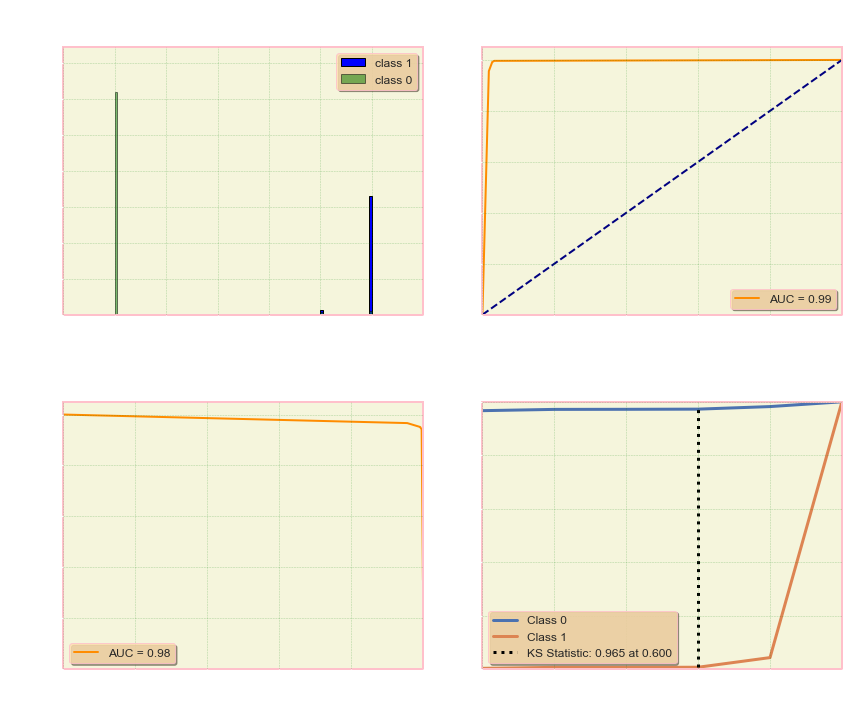

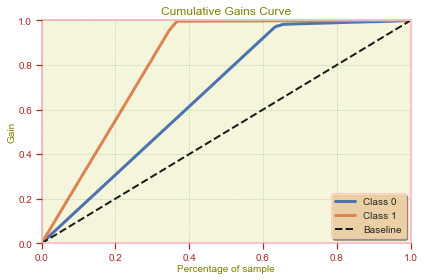

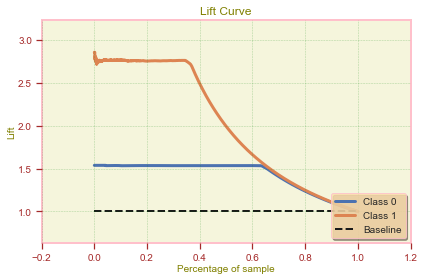

/usr/local/Caskroom/miniconda/base/envs/linh-dev/lib/python3.10/site-packages/scikitplot/metrics.py:1029: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(cmap)(float(i) / len(probas_list))


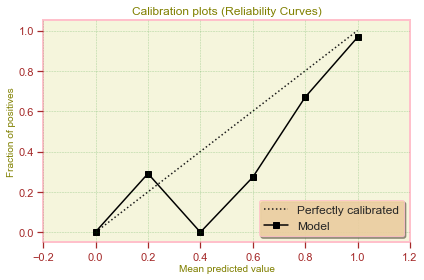

In [24]:
knn_X = pd.get_dummies(data=df[knn_feature], drop_first=True)
knn_X_train = knn_X[knn_X.index.isin(train_index)]
knn_y_train = y[y.index.isin(train_index)]
knn_X_test = knn_X[knn_X.index.isin(test_index)]
knn_y_test = y[y.index.isin(test_index)]
baseline_kNN = KNeighborsClassifier(n_jobs=-1)
baseline_kNN.fit(knn_X_train, knn_y_train)
knn_pred_proba = baseline_kNN.predict_proba(knn_X_test)
metrics(knn_y_test, knn_pred_proba)

- KNN (k = 5) provides a deterministic values as it essentially returns the fraction of neighbors in each class.
- In most cases, the predicted probabilities are influenced by the class labels of the k nearest neighbors, and in many cases, there is a clear majority class among the neighbors.
- Although AUC of precision-recall curve and ROC curves and KS stat are high, the score of 0.96 (in KS) can be observed as the difference between the two classes of predictions, along the x axis at 60% of sample. As can be seen, this distance only occurs for up to ~60% of the data, since the maximum separation starts at a threshold of 0.6, along the x axis, but then decreasing immediately afterwards. 

#### RF without tuning parameters

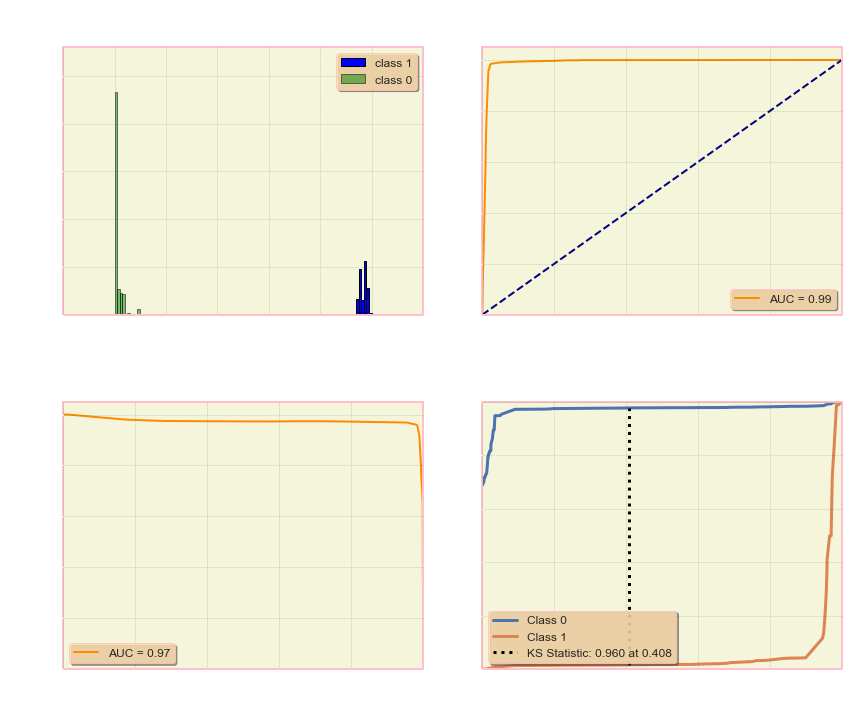

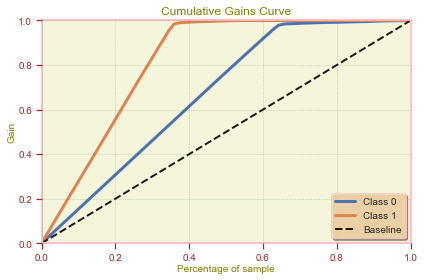

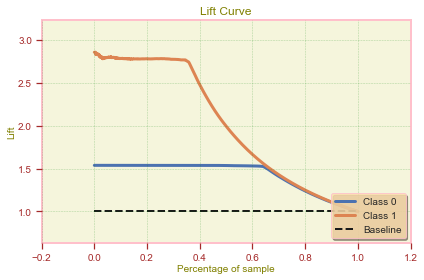

/usr/local/Caskroom/miniconda/base/envs/linh-dev/lib/python3.10/site-packages/scikitplot/metrics.py:1029: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(cmap)(float(i) / len(probas_list))


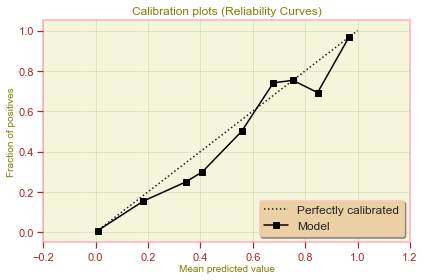

In [25]:
rf_classifier = RandomForestClassifier()
rf_X_train = df[df.index.isin(train_index)][rf_feature]
rf_y_train = y[y.index.isin(train_index)]
rf_X_test = df[df.index.isin(test_index)][rf_feature]
rf_y_test = y[y.index.isin(test_index)]


# Train the classifier on the training data
rf_classifier.fit(rf_X_train, rf_y_train)
rf_pred_proba = rf_classifier.predict_proba(rf_X_test)#[:, 1]
metrics(rf_y_test, rf_pred_proba)

##### TUNING PARAMETERS WITH HYPEROPT, OBJECTIVE METRICS = log_loss

In [26]:
# Define the objective function to minimize (using log-loss as the scoring metric)
class_weight = {}
class_weight[1] = 0.6 #df[df[target] == 1].shape[0] / df[df[target] == 0].shape[0]
class_weight[0] = 1
def objective_function(params):
    # Create a Random Forest classifier with the given hyperparameters
    rf_classifier = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        class_weight = class_weight, # fixed class weight for weighted log_loss
        criterion=params['criterion']
    )

    # Evaluate the classifier using cross-validation with log-loss as the scoring metric
    scores = cross_val_score(rf_classifier, rf_X_train, rf_y_train, cv=5, scoring='neg_log_loss')
    
    # Hyperopt minimizes the objective function, so negate the mean log-loss score
    loss = -scores.mean()

    return loss

# Define the search space for hyperparameters
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 300, 5),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Use the Tree of Parzen Estimators algorithm for optimization
best = fmin(fn=objective_function, space=space, algo=tpe.suggest, max_evals=100)

print("Best hyperparameters:", best)

100%|██████████| 100/100 [10:03<00:00,  6.04s/trial, best loss: 0.08631890230851509]
Best hyperparameters: {'criterion': 0, 'max_depth': 12.0, 'n_estimators': 190.0}


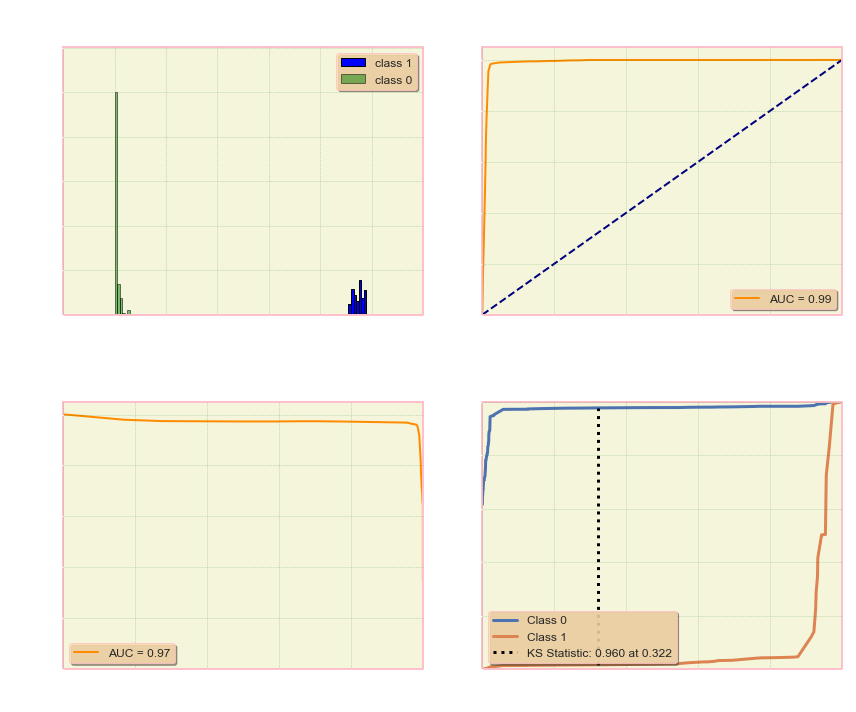

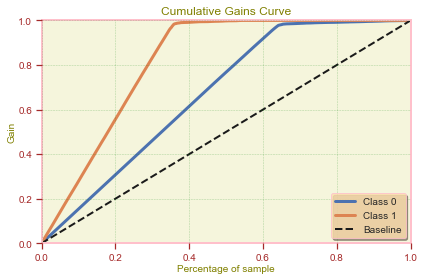

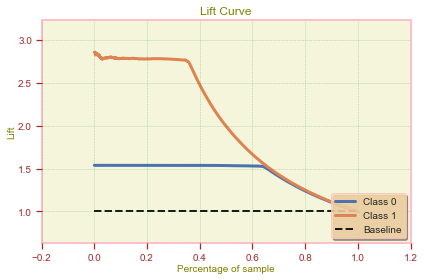

/usr/local/Caskroom/miniconda/base/envs/linh-dev/lib/python3.10/site-packages/scikitplot/metrics.py:1029: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(cmap)(float(i) / len(probas_list))


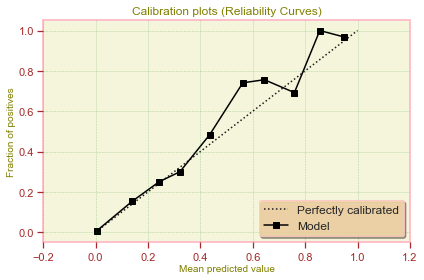

In [35]:
opt_rf_classifier = RandomForestClassifier(
                                        n_estimators=190, 
                                        max_depth = 12, 
                                        criterion = 'gini',
                                        random_state=42,
                                        class_weight = class_weight
                                      )
# Train the classifier on the training data
opt_rf_classifier.fit(rf_X_train, rf_y_train)
rf_pred_proba_opt = opt_rf_classifier.predict_proba(rf_X_test)#[:, 1]
metrics(rf_y_test, rf_pred_proba_opt)

- Random forest has more wide range of prediction probability
- The maximum separation distance between 2 classes is 0.96, at the 30%th of sample, covering for ~70% of data, and also works better with bottom 40% of data compared with kNN

### Model and Result Analysis

In [28]:
result = pd.DataFrame({
    "y_truth": rf_y_test.values,
    "rf_pred_proba": rf_pred_proba_opt[:, 1],
    "knn_pred_proba": knn_pred_proba[:, 1]
})

In [29]:
displayed_columns = ["place", "simplified_place", "visitor_recognition_type", "ua_agent_class", "referer_boolean", "product_content", "product_topic"]
for c in displayed_columns:
    result[c] = df.loc[df.index.isin(test_index), c].values

#### WHICH SORT OF PREDICTION KNN FAILS

##### FALSE POSITIVES

In [30]:
result[(result.knn_pred_proba == 1) & (result.y_truth == 0)].ua_agent_class.value_counts()#.describe()#.rf_pred_proba.describe()

ua_agent_class
Hacker     169
Browser     52
Special      8
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

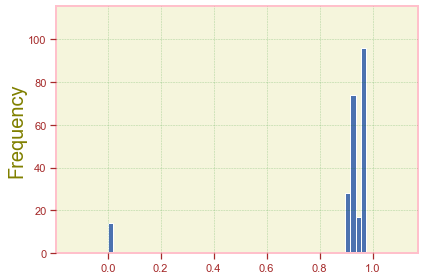

In [31]:
# Plot RF predictio histogram when kNN predicts False Positive
result[(result.knn_pred_proba == 1) & (result.y_truth == 0)].rf_pred_proba.plot.hist(bins=50)

- kNN confidently (and wrongly) predict Hacker as Robot, and those observations are also predicted as Robot with less probability in RF
- Also looking at the histogram of prediction, kNN prediction tends to be more 'black and white'. It's understandable as minority class can be easily outvoted

##### FALSE NEGATIVE 

In [32]:
result[(result.knn_pred_proba == 0) & (result.y_truth == 1)].ua_agent_class.value_counts()#.describe()#.rf_pred_proba.describe()

ua_agent_class
Robot    25
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

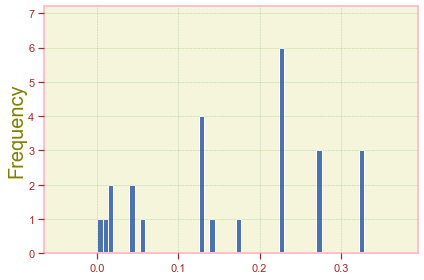

In [33]:
result[(result.knn_pred_proba == 0) & (result.y_truth == 1)].rf_pred_proba.plot.hist(bins=50)#.value_counts()#.describe()#.rf_pred_proba.describe()

##### RANDOM FOREST FEATURE IMPORTANCE

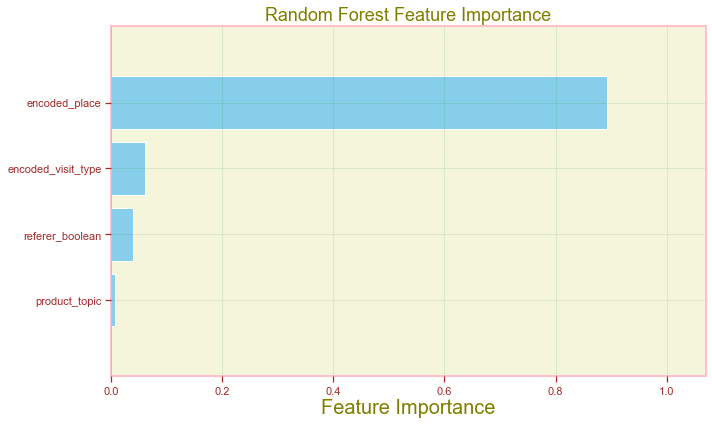

In [34]:
feature_importances = opt_rf_classifier.feature_importances_

# Get feature names (assuming you have access to the feature names)
feature_names = rf_feature  # Replace with your actual feature names

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center', color='skyblue')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

##### As expected, the most importance feature is place (combined of country region)

# SUMMARY AND CONCLUSIONS AND FUTURE WORK 

<div style="background-color: white; padding: 10px; display: inline-block;">
<img src="./img/Model_Comparison_2.png" alt="Alt text" style="width: 1000px;"/>
</div>

- It suggests that the Random Forest model captures the differences in a larger portion of the dataset (which aggregates predictions from multiple trees, might capture broader patterns and allowing it to identify more generalized patterns). One could argue that the Random Forest model is better at distinguishing between the predicted and true distributions across a broader range, while kNN is sensitive to outliers/noiser and local pattern
- kNN likely suffers a lot when the imbalance class is more serious
- One-hot encoding sparsed the data which can hurt distance-based algorithm like kNN, also the curse of dimensionality
- Obviously there're some needed improvement for product topic modeling, or we could have sort of category in the ad database 